<a href="https://colab.research.google.com/github/aashishpiitkEigenlytics/Super-Resolution/blob/main/vgg16_fine_tuning_last_layer_for_header_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os, math, sys
import glob, itertools
import argparse, random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models import vgg19
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid

import plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

random.seed(42)
import warnings
warnings.filterwarnings("ignore")

import math
from pathlib import Path
from torchsummary import summary
import torchvision
from PIL import Image, ImageOps

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# number of epochs of training
n_epochs = 50
# name of the dataset
dataset_path = "/content/train/test/"
# size of the batches
batch_size = 2
# adam: learning rate
lr = 0.00008
# adam: decay of first order momentum of gradient
b1 = 0.5
# adam: decay of second order momentum of gradient
b2 = 0.999
# epoch from which to start lr decay
decay_epoch = 100
# number of cpu threads to use during batch generation
n_cpu = 8
# high res. image height
hr_height = 64
# high res. image width
hr_width = 64
# number of image channels
channels = 1

# os.makedirs("images", exist_ok=True)
# os.makedirs("saved_models", exist_ok=True)

cuda = torch.cuda.is_available()
hr_shape = (hr_height, hr_width)



In [ ]:
! unzip -q /content/drive/MyDrive/rvl_cdip_test_dataset/rvl_cdip_test_dataset.zip -d /content/train

In [ ]:
doc2label = {
    'advertisement':0,
    'budget':1,
    'email':2,
    'file_folder':3,
    'form':4,
    'handwritten':5,
    'invoice':6,
    'letter':7,
    'memo':8,
    'news_article':9,
    'presentation':10,
    'questionnaire':11,
    'resume':12,
    'scientific_publication':13,
    'scientific_report':14,
    'specification':15
}

In [ ]:
train_path = []
for path in Path('/content/train/content/train/test').rglob('*.tif'):
  target = str(str(path).split('/')[-2])
  train_path.append((path, doc2label[target]))

In [ ]:
class ImageDataset(Dataset):
  def __init__(self, files):
    #super(ImageDataset, self)

    self.files = files
    self.trans = transforms.Compose([
                                transforms.Grayscale(),
                                ## earlier it was 1000,780
                                transforms.Resize((780,600)), 
                                transforms.ToTensor()
    ])
    self.trans2 = transforms.Resize((227,227))
    self.trans1 = transforms.ToTensor()
    #self.trans1 = transforms.ToTensor()
  
  def __getitem__(self, index):
    img = Image.open(self.files[index % len(self.files)][0])
    target = self.files[index % len(self.files)][1]
    
    output_dict = {
        'targets' : torch.tensor(target),
        # 'holistic' : self.create_holistic(img),
        'header' : self.create_header(img),
        #'holistic' : self.create_holistic(img),
        #'footer' : self.create_footer(img),
        #'right' : self.create_right_half(img),
        #'left' : self.create_left_half(img)
        # 'original' : torch.tensor(img)
    }

    return output_dict
  
  def create_header(self, x):
    # trans1 = transforms.ToTensor()
    x = self.trans(x)

    x = x[:][:, :256, :]
    return self.trans2(x)


  def create_right_half(self, x):
    x = self.trans(x)

    x = x[:][:, 100:-100, -300:]
    return self.trans2(x)

  def create_left_half(self, x):
    x = self.trans(x)

    x = x[:][:, 100:-100, :300]
    return self.trans2(x)
  def create_footer(self, x):
    x = self.trans(x)

    x = x[:][:, -256:, :]
    return self.trans2(x)

  def create_holistic(self, x):
    
    return self.trans(x)

  def __len__(self):
      return len(self.files)


In [ ]:
# train_path = train_path[:len(train_path)//5]

In [ ]:
len(train_path)

39996

In [ ]:
## incorporate the labels somehow when preparing the dataset usign ImageDataset

In [ ]:
train_paths, test_paths = train_test_split(train_path, test_size=0.1)
train_paths = train_paths[:len(train_paths)//2]
test_paths = test_paths[:len(test_paths)//3]

#train_paths, test_paths = train_test_split(sorted(glob.glob(dataset_path + "/*.*")), test_size=0.02, random_state=42)
train_dataloader = DataLoader(ImageDataset(train_paths), batch_size=batch_size, shuffle=True, num_workers=n_cpu)
test_dataloader = DataLoader(ImageDataset(test_paths), batch_size=int(batch_size), shuffle=True, num_workers=n_cpu)

In [ ]:
len(train_dataloader)

8999

In [ ]:
iterator = iter(train_dataloader)
batch = next(iterator)

In [ ]:
print(batch['header'].shape, batch['holistic'].shape, batch['footer'].shape, batch['right'].shape, batch['left'].shape)

torch.Size([2, 1, 227, 227]) torch.Size([2, 1, 780, 600]) torch.Size([2, 1, 227, 227]) torch.Size([2, 1, 227, 227]) torch.Size([2, 1, 227, 227])


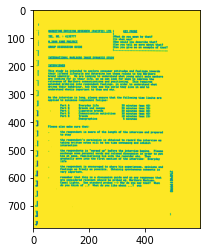

In [ ]:
plt.imshow(batch['holistic'][0,:,:,:].squeeze().cpu().detach().numpy())

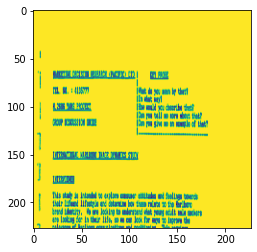

In [ ]:
plt.imshow(batch['header'][0,:,:,:].squeeze().cpu().detach().numpy())

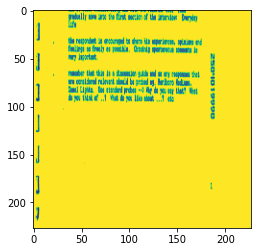

In [ ]:
plt.imshow(batch['footer'][0,:,:,:].squeeze().cpu().detach().numpy())

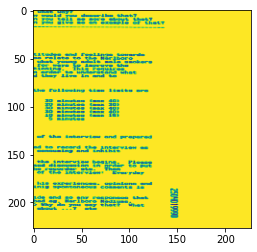

In [ ]:
plt.imshow(batch['right'][0,:,:,:].squeeze().cpu().detach().numpy())

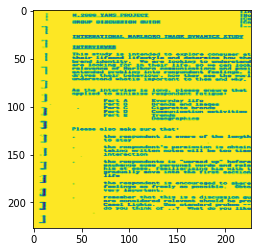

In [ ]:
plt.imshow(batch['left'][0,:,:,:].squeeze().cpu().detach().numpy())

In [ ]:
class VGG16_fine_tune_last_layer(nn.Module):
  def __init__(self):
    super(VGG16_fine_tune_last_layer, self).__init__()

    vgg16_model = torchvision.models.vgg16(pretrained = True)
    self.feature_extractor = nn.Sequential(*list(vgg16_model.features.children()))
    self.avg_pool = vgg16_model.avgpool#nn.Sequential(*list(vgg16_model.avgpool.children()))
    self.classifier = nn.Sequential(*list(vgg16_model.classifier.children())[:-1])

    for name, param in self.feature_extractor.named_parameters():
      param.requires_grad = False
    for name, param in self.avg_pool.named_parameters():
      param.requires_grad = False
    for name, param in self.classifier.named_parameters():
      param.requires_grad = False

    self.last_layer = nn.Linear(4096, 16, bias=True)

  def forward(self, x):
    x = self.feature_extractor(x)
    x = self.avg_pool(x)
    x = self.classifier(torch.flatten(x, start_dim=1))
    
    output = self.last_layer(x)
    return output


In [ ]:
vgg16_fine_tune_last_layer = VGG16_fine_tune_last_layer().to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [ ]:
for name, param in vgg16_fine_tune_last_layer.named_parameters():
    if param.requires_grad:
        print(name)

last_layer.weight
last_layer.bias


In [ ]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, vgg16_fine_tune_last_layer.parameters()), 
                             lr=lr, betas=(b1, b2))

criterion = nn.CrossEntropyLoss()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# ## loading the weights
# checkpoint = torch.load("/content/drive/MyDrive/vgg16_last_layer_fine_tune_rvl_cdip/checkpt18.pt",map_location=torch.device(device))

# vgg16_fine_tune_last_layer.load_state_dict(checkpoint['vgg16_fine_tune_last_layer'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# vgg16_fine_tune_last_layer.train()

In [ ]:
for param_tensor in vgg16_fine_tune_last_layer.state_dict():
  print(param_tensor, "\t", vgg16_fine_tune_last_layer.state_dict()[param_tensor].size())

feature_extractor.0.weight 	 torch.Size([64, 3, 3, 3])
feature_extractor.0.bias 	 torch.Size([64])
feature_extractor.2.weight 	 torch.Size([64, 64, 3, 3])
feature_extractor.2.bias 	 torch.Size([64])
feature_extractor.5.weight 	 torch.Size([128, 64, 3, 3])
feature_extractor.5.bias 	 torch.Size([128])
feature_extractor.7.weight 	 torch.Size([128, 128, 3, 3])
feature_extractor.7.bias 	 torch.Size([128])
feature_extractor.10.weight 	 torch.Size([256, 128, 3, 3])
feature_extractor.10.bias 	 torch.Size([256])
feature_extractor.12.weight 	 torch.Size([256, 256, 3, 3])
feature_extractor.12.bias 	 torch.Size([256])
feature_extractor.14.weight 	 torch.Size([256, 256, 3, 3])
feature_extractor.14.bias 	 torch.Size([256])
feature_extractor.17.weight 	 torch.Size([512, 256, 3, 3])
feature_extractor.17.bias 	 torch.Size([512])
feature_extractor.19.weight 	 torch.Size([512, 512, 3, 3])
feature_extractor.19.bias 	 torch.Size([512])
feature_extractor.21.weight 	 torch.Size([512, 512, 3, 3])
feature_extr

In [ ]:
# # save only model.state_dict()['last_layer.weight'] and model.state_dict()['last_layer.bias']
# new_state_dict = {}
# layers = ['last_layer.weight', 'last_layer.bias']
# for layer in layers:
#   print(vgg16_fine_tune_last_layer.state_dict()[layer].shape)
#   new_state_dict[layer] = vgg16_fine_tune_last_layer.state_dict()[layer]

In [ ]:
# for param_tensor in new_state_dict:
#   print(param_tensor, "\t", new_state_dict[param_tensor].size())

In [ ]:
## loading the weights
checkpoint = torch.load("/content/drive/MyDrive/vgg16_last_layer_fine_tune_rvl_cdip/checkpt18.pt",map_location=torch.device(device))

new_state_dict = checkpoint['new_state_dict']
old_dict = vgg16_fine_tune_last_layer.state_dict()
old_dict['last_layer.weight'] = new_state_dict['last_layer.weight']
old_dict['last_layer.bias'] = new_state_dict['last_layer.bias']
vgg16_fine_tune_last_layer.load_state_dict(old_dict)


optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

vgg16_fine_tune_last_layer.train()



VGG16_fine_tune_last_layer(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2,

In [ ]:
## we will save and load this dictionary only

In [ ]:
def accuracy(x, targets):
  # receive the outputs of linear layer
  # first apply softmax then take argmax to know the index
  # then compare
  # input will be (batch_size, )
  probs = nn.functional.softmax(x)
  labels = torch.argmax(probs, dim=1)

  count=0
  for label, target in zip(labels, targets):
    #print(label, target)
    if(label.item() == target.item()):
      count+=1
  
  return count/labels.shape[0]



In [ ]:
train_losses, test_losses = [], []
train_acc, test_acc = [], []
test_counter = [idx*len(test_dataloader.dataset) for idx in range(1, n_epochs+1)]
train_counter = [idx*len(train_dataloader.dataset) for idx in range(1, n_epochs+1)]

for epoch in range(n_epochs):

  ## Training loop
  loss = 0
  acc = 0
  tqdm_bar = tqdm(train_dataloader, desc=f'Training Epoch {epoch} ', total=int(len(train_dataloader)))

  for batch_idx, imgs in enumerate(tqdm_bar):

    optimizer.zero_grad()


    vgg16_fine_tune_last_layer.train();

    for key in imgs:
      imgs[key] = imgs[key].to(device)

    holistic_img = imgs['header']
    targets = imgs['targets']


    ## convert the 1 channel image to 3 channel image
    holistic_img_3 = holistic_img.repeat_interleave(3, dim=1)
    holistic_img_3[:, 1:3, :, :] = 0

    prediction = vgg16_fine_tune_last_layer(holistic_img_3.to(device))

    loss_calc = criterion(prediction.to(device), targets.to(device))

    loss_calc.backward()
    optimizer.step()

    loss += loss_calc.item()
    acc += accuracy(prediction.to(device), targets.to(device))
    tqdm_bar.set_postfix(loss=loss/(batch_idx+1), acc = acc/(batch_idx+1))

  train_losses.append(loss/len(train_dataloader)) ## divided by total number of batches



  


  ## Testing loop
  loss = 0
  acc = 0
  tqdm_bar = tqdm(test_dataloader, desc=f'Testing Epoch {epoch} ', total=int(len(test_dataloader)))

  for batch_idx, imgs in enumerate(tqdm_bar):

    vgg16_fine_tune_last_layer.eval();
    
    for key in imgs:
      imgs[key] = imgs[key].to(device)

    holistic_img = imgs['header']
    targets = imgs['targets']
    
    ## convert the 1 channel image to 3 channel image
    holistic_img_3 = holistic_img.repeat_interleave(3, dim=1)
    holistic_img_3[:, 1:3, :, :] = 0
    
    prediction = vgg16_fine_tune_last_layer(holistic_img_3.to(device))

    loss_calc = criterion(prediction.to(device), targets.to(device))

    loss += loss_calc.item()
    acc += accuracy(prediction.to(device), targets.to(device))
    tqdm_bar.set_postfix(loss=loss/(batch_idx+1), acc = acc/(batch_idx+1))

  test_losses.append(loss/len(test_dataloader)) ## divided by total number of batches


  new_state_dict = {}
  layers = ['last_layer.weight', 'last_layer.bias']
  for layer in layers:
    #print(vgg16_fine_tune_last_layer.state_dict()[layer].shape)
    new_state_dict[layer] = vgg16_fine_tune_last_layer.state_dict()[layer]

  if(True):
    torch.save({
          
          'new_state_dict' : new_state_dict,
          'optimizer_state_dict': optimizer.state_dict(),
          'train_loss' : train_losses[-1],
          'test_loss' : test_losses[-1],
          'epoch': epoch+1,
          }, f"/content/drive/MyDrive/vgg16_fine_tune_last_layer_header/checkpt{epoch+1}.pt")

KeyboardInterrupt: ignored

In [ ]:
out = nn.functional.softmax(torch.randn(4,10), dim=1)
print(out.shape, torch.argmax(out, dim=1).shape)

torch.Size([4, 10]) torch.Size([4])


In [ ]:
for i, j in zip(range(5), range(3)):
  print(i,j)

0 0
1 1
2 2


In [ ]:
torch.tensor([1,2,3]).shape

torch.Size([3])

In [ ]:
print(accuracy(torch.randn(6, 16).to(device), torch.tensor([1,2,3,4,5,6]).to(device)))

tensor(11, device='cuda:0') tensor(1, device='cuda:0')
tensor(2, device='cuda:0') tensor(2, device='cuda:0')
tensor(9, device='cuda:0') tensor(3, device='cuda:0')
tensor(6, device='cuda:0') tensor(4, device='cuda:0')
tensor(6, device='cuda:0') tensor(5, device='cuda:0')
tensor(1, device='cuda:0') tensor(6, device='cuda:0')
0.16666666666666666


In [ ]:
# vgg16 = models.vgg16(pretrained=True)

In [ ]:
# modify the last layer to give output to 16 classes
# no need to attach softmax at last as cross entropy loss automatically takes care of that in pytorch by appling softmax automatically

In [ ]:
# one way is to delete the last layer and then add a new layer with the required specification
# second way is to modify the layer

In [ ]:
# temp = nn.Conv2d(2,64,3)


In [ ]:
# print(temp.parameters())

In [ ]:
# for parameter in temp.parameters():
#   print(parameter)

In [ ]:
# print(temp.in_channels)

In [ ]:
# temp.in_channels = 3

In [ ]:
# print(temp.in_channels, temp.out_channels)

In [ ]:
# for child_counter, child in enumerate(vgg16.children()):
#   print("child", child_counter, "is -")
#   print(child)

In [ ]:
# for child_index, child in enumerate(vgg16.children()):
#   if(child_index == 2):
#     for sub_child_index, sub_child in enumerate(child.children()):
#       if(sub_child_index == 6):
#         sub_child.out_features = 16
#   # if(child_index == 0):
#   #   for sub_child_index, sub_child in enumerate(child.children()):
#   #     if(sub_child_index == 0):
#   #       sub_child.in_channels = 1

In [ ]:
# for child_counter, child in enumerate(vgg16.children()):
#   print("child", child_counter, "is -")
#   print(child)

In [ ]:
# freeze all the layers except the last fully connected layer for first experiment

In [ ]:
# for child_index, child in enumerate(vgg16.children()):
#   for sub_child_index, sub_child in enumerate(child.children()):
#     if(not((sub_child_index == 6) and (child_index == 2))):
#       for parameter in sub_child.parameters():
#         parameter.requires_grad = False
#     else:
#       for parameter in sub_child.parameters():
#         parameter.requires_grad = True

In [ ]:
# # check if the requries_grad is false for the requrid layers
# for child_index, child in enumerate(vgg16.children()):
#   for sub_child_index, sub_child in enumerate(child.children()):
#     if(not((sub_child_index == 6) and (child_index == 2))):
#       for parameter in sub_child.parameters():
#         print(sub_child, parameter.requires_grad)
#     else:
#       for parameter in sub_child.parameters():
#         print(sub_child, parameter.requires_grad)

In [ ]:
# initialize the optimizer carefully as you have frozen some of the layers

In [ ]:
# now we are ready to train


In [ ]:
## prepare the data with labels

In [ ]:
## using the module concept
# first delete the last layer
# then add a linear layer by using a nn.Module class


In [ ]:
# vgg16.features

In [ ]:
# print(vgg16)

In [ ]:
# vgg16.classifier

In [ ]:
# layers = []
# for child_counter, child in enumerate(vgg16.children()):
#   if(child_counter<2): 
#     layers.append(child)
#   else:
#     layers.append(nn.Sequential(*list(child.children())[:-1]))

In [ ]:
# print(layers)

In [ ]:
# feature_extractor = nn.Sequential(*list(vgg16.features.children()))
# print(feature_extractor(torch.randn(4,3,512,512)).shape)

In [ ]:
# avg_pool = vgg16.avgpool#nn.Sequential(*list(vgg16.avgpool.children()))
# print(avg_pool(torch.randn(4,512,16,16)).shape)

In [ ]:
# print(torch.flatten(torch.randn(4,512,7,7)).shape)

In [ ]:
# classifier = nn.Sequential(*list(vgg16.classifier.children()))
# print(classifier(torch.flatten(torch.randn(4,512,7,7), start_dim=1)).shape)

In [ ]:
# del vgg16_fine_tune_last_layer

In [ ]:
## Hence it is verified that only the last layer is trainable

In [ ]:
#################################################
##################################################
################################################################
#####################################################################
############################################################################

In [ ]:
# ! pip install -q kaggle

In [ ]:
# from google.colab import files
# files.upload()

In [ ]:
# % ls

In [ ]:
# % mkdir ~/.kaggle/

In [ ]:
# ! cp kaggle.json ~/.kaggle/

In [ ]:
# ! kaggle datasets download -d pdavpoojan/the-rvlcdip-dataset-test

In [ ]:
# ! chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# % mkdir train

In [ ]:
# torch.cuda.empty_cache()

In [ ]:
## to delete the whole directory
##import shutil
##shutil.rmtree('/content/kaggle/test')

In [ ]:
# ! unzip -q /content/the-rvlcdip-dataset-test.zip -d /content/train 

In [ ]:
# ## to remove the curropted files
# import cv2
# for dirname, _, filenames in os.walk("/content/train/test/"):
#     for filename in filenames:
#         if not hasattr(cv2.imread(os.path.join(dirname, filename)), "shape"):
#             os.remove(os.path.join(dirname,filename))

In [ ]:
# ! zip -q -r /content/drive/MyDrive/rvl_cdip_test_dataset/rvl_cdip_test_dataset.zip /content/train/test/

In [ ]:
# for file in train_path:
#   print(file[1])

In [ ]:
# trans1 = transforms.ToTensor()
# print(torch.tensor(8))

In [ ]:
# iterator = iter(train_dataloader)
# batch = next(iterator)

In [ ]:
# print(batch['holistic'].shape)

In [ ]:
# print(iterator.shape)

In [ ]:
# # check if the requries_grad is false for the requrid layers
# for child_index, child in enumerate(vgg16.to(device).children()):
#   for sub_child_index, sub_child in enumerate(child.children()):
#     if(not((sub_child_index == 6) and (child_index == 2))):
#       for parameter in sub_child.parameters():
#         print(sub_child, parameter.requires_grad)
#     else:
#       for parameter in sub_child.parameters():
#         print(sub_child, parameter.requires_grad)

In [ ]:
# output = vgg16(torch.randn(1,3,512,512))
# print(output.shape)

In [ ]:
# summary(vgg16.to(device), (3,512,512))